In [127]:
# 6.1 テキストデータの操作

# リスト 6-1: 単語レベルでの単純な one-hot エンコーディング
import numpy as np

# 初期データ: サンプルごとにエントリが1つ含まれている
# （この単純な例では、サンプルは単なる1つの文章だが、文書全体でもよい）
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# データに含まれているすべてのトークンのインデックスを構築
token_index = {}
for sample in samples:
    # ここでは単純にsplitメソッドを使ってサンプルをトークン化する
    # 実際には、サンプルから句読点と特殊な文字を取り除くことになる
    for word in sample.split():
        if word not in token_index:
            # 一意な単語にそれぞれ一意なインデックスを割り当てする
            # インデックス0をどの単語にも割り当てないことに注意
            token_index[word] = len(token_index) + 1

# 次に、サンプルをベクトル化する：サンプルごとに最初の max_length 個の単語だけを考慮
max_length = 10

# 結果の格納場所
results = np.zeros((len(samples),
                    max_length,
                    max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

In [128]:
# リスト 6-2: 文字レベルでの単純なone-hotエンコーディング
import string

samples = ['The cat sat on my mat.', 'The dog ate my homework.']
characters = string.printable  # 全て印字可能なASCII文字
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples),
                   max_length,
                   max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [129]:
# リスト 6-3: Kerasを使った単語レベルでの one-hot エンコーディング
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# 出現頻度が最も高い1,000個の単語だけを処理するように設定された
# トークナイザを作成
tokenizer = Tokenizer(num_words=1000)

# 単語のインデックスを構築
tokenizer.fit_on_texts(samples)

# 文字列を整数のインデックスのリストに変換
sequences = tokenizer.texts_to_sequences(samples)

# 二値のone-hotエンコーディング表現を直接取得することも可能
# one-hotエンコーディング以外のベクトル化モードもサポートされている
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# 計算された単語にインデックスを復元する方法
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

print('tokeninzer:', tokenizer.fit_on_texts(samples))
print('sequences:', sequences)
print('one_hot_results:', one_hot_results)

Found 9 unique tokens.
tokeninzer: None
sequences: [[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]
one_hot_results: [[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [130]:
# リスト 6-4: ハッシュトリックを用いた単語レベルの単純なone-hotエンコーディング
samples = ['The cat sat on the mat.', 'The dot ate my homework.']

# 単語をサイズが1,000のベクトルとして格納
# 単語の数が1,000の数に近い（またはそれ以上である場合は）
# ハッシュ衝突が頻発し、このエンコーディング手法の精度が低下することに注意
dimentionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimentionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # 単語をハッシュ化し、0~1000のランダムな整数に変換
        index = abs(hash(word)) % dimentionality
        results[i, j, index] = 1.

In [131]:
# 6.1.2 単語埋め込み - word embedding

# リスト 6-5: Embedding 層をインスタンス化
from keras.layers import Embedding

# Embedding層の引数は少なくとも2つ:
#   有効なトークンの数: この場合は1,000(1 + 単語のインデックスの最大値)
#   埋め込みの次元の数: この場合は64
embedding_layer = Embedding(1000, 64)

In [132]:
# リスト 6-6: Embedding層で使用するIMDbデータを読み込む
from keras.datasets import imdb
from keras import preprocessing

# 特徴量として考慮する単語の数
max_features = 10000

# max_features 個の最も出現頻度の高い単語のうち
# 個の数の単語を残してテキストをカット
max_len = 20

# データを整数のリストとして読み込む
(x_train, y_train), (x_test, y_test) = \
    imdb.load_data(num_words=max_features)

# 整数のリストを形状が(samples, max_len)の整数型の2次元テンソルに変換
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [133]:
# リスト 6-7: IMDbデータで Embedding 層と分類器を使用
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()

# あとから埋め込み入力を平坦化できるよう、
# Embedding層に入力の長さとしてmax_lenを指定
# Embedding層の後、活性化の形状は(samples, max_len, 8)になる
model.add(Embedding(10000, 8, input_length=max_len))

# 埋め込みの3次元テンソルを形状が(samples, max_len * 8)の2次元テンソルに変換
model.add(Flatten())

# 最後に分類器を追加
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 20, 8)             80000     
_________________________________________________________________
flatten_20 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 83us/step - loss: 0.6759 - acc: 0.6049 - val_loss: 0.6398 - val_acc: 0.6812
Epoch 2/10
20000/20000 [==============================] - 1s 49us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7204
Epoch 3/10
20000/20000 [==============================] - 1s 46us/step - loss: 

In [134]:
# 6.1.3 テキストのトークン化から埋め込みまで

# リスト 6-8: 元のIMDbデータセットのラベルを処理
import os

imdb_dir = '/Users/sunouchi/Downloads/aclImdb'

train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [135]:
# リスト 6-9: IMDbデータのテキストをトークン化
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len = 100               # 映画レビューを100ワードでカット
training_samples = 10000      # 200個のサンプルで訓練
validation_samples = 10000  # 10,000個のサンプルで検証
max_words = 10000           # データセットの最初から10,000ワードのみを考慮

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=max_len)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# データを訓練データセットと検証データセットに分割：
# ただし、サンプルが順番に並んでいる（否定的なレビューの後に肯定的なレビューが
# 配置されている）状態のデータを使用するため、最初にデータをシャッフル
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


((10000, 100), (10000,), (10000, 100), (10000,))

In [136]:
# 埋め込みの前処理

# リスト 6-10: Gloveの単語埋め込みの準備

# Gloveの埋め込みファイルが置かれているディレクトリ
glove_dir = '/Users/sunouchi/Downloads/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [137]:
# リスト 6-11: Gloveの単語埋め込み行列の準備
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 埋め込みインデックスで見つからない単語は0で埋める
            embedding_matrix[i] = embedding_vector

In [138]:
# モデルの定義

# リスト 6-12: モデルの定義
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_21 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Gloveの埋め込みをモデルに読み込む

# リスト6-13: 準備した単語埋め込みを Embedding層に読み込む
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [140]:
# モデルの訓練と評価

# リスト6-14: 訓練と評価
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 2s 211us/step - loss: 0.6911 - acc: 0.5868 - val_loss: 0.6402 - val_acc: 0.6524
Epoch 2/10
10000/10000 [==============================] - 2s 164us/step - loss: 0.6000 - acc: 0.7049 - val_loss: 0.6100 - val_acc: 0.6909
Epoch 3/10
10000/10000 [==============================] - 2s 155us/step - loss: 0.5218 - acc: 0.7491 - val_loss: 0.5925 - val_acc: 0.6988
Epoch 4/10
10000/10000 [==============================] - 2s 167us/step - loss: 0.4381 - acc: 0.7971 - val_loss: 0.8721 - val_acc: 0.6221
Epoch 5/10
10000/10000 [==============================] - 2s 164us/step - loss: 0.3842 - acc: 0.8275 - val_loss: 0.6359 - val_acc: 0.7047
Epoch 6/10
10000/10000 [==============================] - 2s 159us/step - loss: 0.3308 - acc: 0.8584 - val_loss: 0.9775 - val_acc: 0.6477
Epoch 7/10
10000/10000 [==============================] - 2s 165us/step - loss: 0.2763 - acc: 0.8834 - val_loss: 0.8591 - 

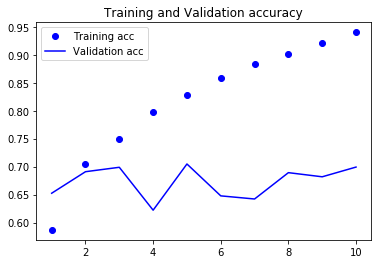

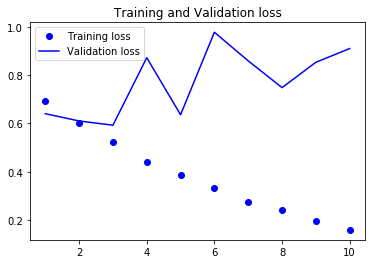

In [141]:
# リスト 6-15: 結果をプロット

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +  1)

# 正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_22 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 147us/step - loss: 0.6560 - acc: 0.6253 - val_loss: 0.5515 - val_acc: 0.7637
Epoch 2/10
10000/10000 [==============================] - 1s 79us/step - los

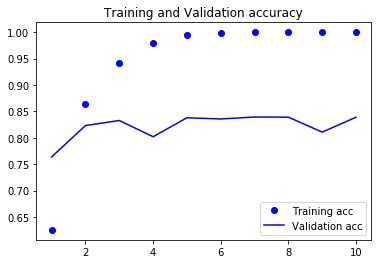

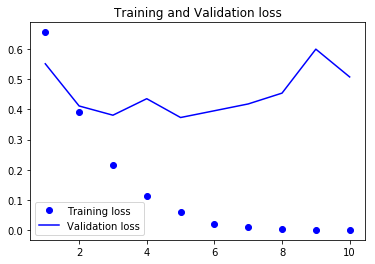

In [142]:
# リスト 6-16: 学習済みの単語埋め込みを使用せずに同じモデルを訓練

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                     epochs=10,
                     batch_size=512,
                     validation_data=(x_val, y_val))


# グラフをプロット
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +  1)

# 正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [143]:
# リスト 6-17: テストデータセットのデータをトークン化
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [145]:
# リスト 6-18: モデルをテストデータセットで評価する
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 53us/step


[0.9051732854747773, 0.69476]